In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline
sns.set(style="white")

Data sources:

1. Crytocurrency market data for the coins: bitcoin, ethereum, litecoin, ripple
2. Stocktwits user-provided sentiment data fetched using Quantopian
3. Google trends data on search terms for the above coins (Strong correlation as per Google Correlate)

In [2]:
# 1. Cryptocurrency market data
# get market data for cryptocurrencies from the start of Aug 7, 2015 to Feb 14
start_date = "20150807"
end_date = "20180412"

start_date_ = '2015-08-07'
end_date_ = '2018-04-12'


In [3]:
# TODO: Add config class/file that is accessible to all notebooks
coins = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
coin_df = {}

In [4]:
for coin in coins:
    coin_df[coin] = pd.read_html("https://coinmarketcap.com/currencies/"+coin+"/historical-data/?start="+start_date+"&end="+end_date)[0]
    coin_df[coin] = coin_df[coin].assign(Date=pd.to_datetime(coin_df[coin]['Date']))
    
    # reverse the data frame so that subsequent rows represent later timepoints
    coin_df[coin] = coin_df[coin].sort_values(by='Date').reset_index(drop=True)
    
    coin_df[coin].to_pickle("data/"+coin+".pkl")

In [5]:
coin_df['bitcoin'].tail()

,Date,Open,High,Low,Close,Volume,Market Cap
975,2018-04-08,6919.98,7111.56,6919.98,7023.52,3652500000,117392000000
976,2018-04-09,7044.32,7178.11,6661.99,6770.73,4894060000,119516000000
977,2018-04-10,6795.44,6872.41,6704.15,6834.76,4272750000,115306000000
978,2018-04-11,6843.47,6968.32,6817.59,6968.32,4641890000,116126000000
979,2018-04-12,6955.38,7899.23,6806.51,7889.25,8906250000,118048000000


In [6]:
coin_df['bitcoin'].dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
Market Cap             int64
dtype: object

In [7]:
coin_df['bitcoin'].describe()

,Open,High,Low,Close,Volume,Market Cap
count,980.000000,980.000000,980.000000,980.000000,9.800000e+02,9.800000e+02
mean,2799.266051,2906.104551,2680.363153,2806.535061,1.843450e+09,4.645561e+10
std,3967.730832,4149.260772,3741.780966,3969.698130,3.743145e+09,6.683607e+10
min,210.070000,226.320000,199.570000,210.500000,1.271260e+07,3.053250e+09
25%,442.485000,448.147500,435.647500,442.610000,6.078130e+07,6.745750e+09
50%,772.330000,777.540000,765.135000,773.330000,1.332780e+08,1.237835e+10
75%,3371.120000,3529.840000,3265.620000,3390.945000,1.515760e+09,5.560972e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11


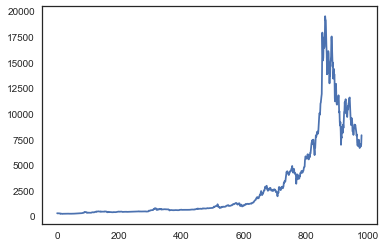

In [8]:
plt.plot(coin_df['bitcoin']['Close'])

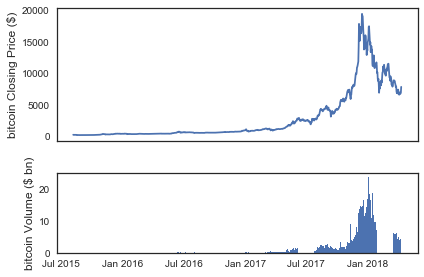

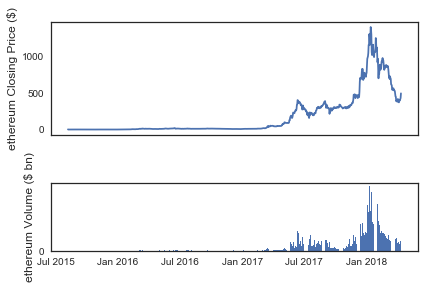

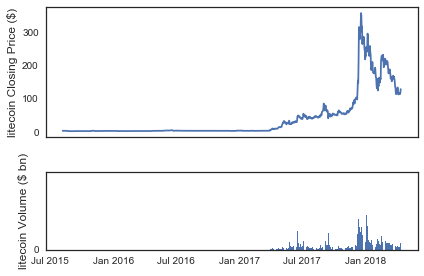

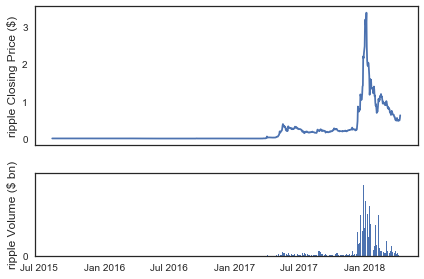

In [9]:
for coin in coins:
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 3]})
    ax1.set_ylabel(coin+' Closing Price ($)',fontsize=12)
    ax2.set_ylabel(coin+' Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in [0, 10, 20, 30]])
    ax2.set_yticklabels([0, 10, 20, 30])
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(coin_df[coin]['Date'],coin_df[coin]['Close'])
    ax2.bar(coin_df[coin]['Date'].values, coin_df[coin]['Volume'].values)
    fig.tight_layout()
    plt.show()

Onto the 2nd Data Source: Sentiment from Stocktwits

Raw tweets are not accessed, instead the bullish and bearish sentiment information is fetched directly. This is the sentiment expressed by users on stocktwits.

Leveraged the Qunatopian platform directly to export the required dataset

Code here: https://www.quantopian.com/research/notebooks/Updated%20PsychSignal.Stockwits.ipynb 
Also checked-into Github capstone area

Google trends is the last data source used. Used the python package pytrends to fetch daily google search results data for the keywords "bitcoin" and "ethereum" seperately.

Since Google trends provides daily data only if the search window is less than 6 months and normalizes the data on a scale of 1 to 100, I had to create multiple short queries and then accumulate the data for the required time window. While accumulating, I also took care to re-scale the data by having an overlap time window between each successive queries (Code below)

In [10]:
from pytrends.request import TrendReq
from datetime import datetime, timedelta

# Connect to Google
pytrend = TrendReq(hl='de-CH')
# pytrend = TrendReq(hl='en-US', tz=360)

In [11]:
# Generates per-day google trends data even when query duration is greater than 6 months
# Accumulates data by using multiple queries and scaling query results appropriately 
# by having overlapped dates in successive queries 
def get_trends_data (keyword, start_date, end_date, overlap):
    
    print ("!!!!!!!!!!Searching for keyword: ", keyword)
    
    # this works as of 4/14 for at least the search terms I tried. Google trends might change its behavior
    max_delta = 180 # in days
    
    # Create time_set array
    time_set = []
    first = start_date
    last = start_date
    while last < end_date:
        last = min(end_date, first + timedelta(days=max_delta))
        time_set.append(first.strftime('%Y-%m-%d')+' '+last.strftime('%Y-%m-%d'))
        first = (last + timedelta(days=1)) - timedelta(days=overlap)
                  
    # print (time_set)
    
    # Initialize output dataframe
    results_df = pd.DataFrame()

    # Skip re-scaling for the first iteration
    first_iter = 1

    for time_dur in time_set:
        pytrend.build_payload(kw_list=[keyword], timeframe=time_dur, geo='', gprop='')
        trend_df = pytrend.interest_over_time()
    
        if first_iter == 1:
            first_iter = 0
            overlap = 0
        else:
            overlap = (prev_end_date - trend_df.index[0]).days + 1
            # print (overlap)
    
            if overlap < 1:
                print ("ERROR: Killing since overlap is not even one day: Overlap =", overlap)
                exit(1)
            else:
                print ("Proceeding since overlap is", overlap)
      
            if overlap > 1:
                prev_df = results_df.iloc[-1*overlap:][keyword]
                curr_df = trend_df.iloc[:overlap][keyword]
                scale_fac = np.mean(1.0*prev_df/curr_df)
                print (scale_fac)
            else:
                print ("Overlap is greater than 1. overlap =", overlap)
        
            trend_df[keyword] *= scale_fac
    
        prev_end_date = trend_df.index[-1]
    
        # Interest Over Time
        results_df = results_df.append(trend_df.iloc[overlap:]) #, ignore_index = True)

    return results_df

In [12]:
start_date_format = datetime.strptime(start_date_, '%Y-%m-%d')
end_date_format = datetime.strptime(end_date_, '%Y-%m-%d')

overlap = 10

keywords = ['bitcoin', 'ethereum', 'litecoin', 'ripple']
keyword_df = {}

!!!!!!!!!!Searching for keyword:  bitcoin
Proceeding since overlap is 10
1.1962331678747389
Proceeding since overlap is 10
1.3880077654805016
Proceeding since overlap is 10
4.112245818335194
Proceeding since overlap is 10
23.513234125552305
Proceeding since overlap is 10
25.059162257595993
!!!!!!!!!!Searching for keyword:  ethereum
Proceeding since overlap is 10
5.209667832167833
Proceeding since overlap is 10
3.015359347711884
Proceeding since overlap is 10
41.48631902560267
Proceeding since overlap is 10
56.303070085999124
Proceeding since overlap is 10
55.33360998048539
!!!!!!!!!!Searching for keyword:  litecoin
Proceeding since overlap is 10
1.350471026101351
Proceeding since overlap is 10
1.266222907389015
Proceeding since overlap is 10
20.850470541672447
Proceeding since overlap is 10
301.636807169528
Proceeding since overlap is 10
296.5348478726716
!!!!!!!!!!Searching for keyword:  ripple
Proceeding since overlap is 10
0.9735750670196046
Proceeding since overlap is 10
1.33676119

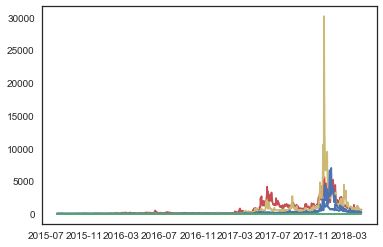

In [13]:
for search_term in keywords:
    keyword_df[search_term] = get_trends_data(search_term, start_date_format, end_date_format, overlap)
    plt.plot(keyword_df[search_term])

In [14]:
# Impute unavailable trends data (since we don't have the data yet for 4-12-2018 for Google Trends)
for search_term in keywords:
    while (keyword_df[search_term].index[-1] < end_date_format+ timedelta(days=6)):
        new_date = keyword_df[search_term].index[-1] + timedelta(days=1)
        new_entry = pd.DataFrame(keyword_df[search_term][-1:].values, index=[new_date], columns=keyword_df[search_term].columns)
        
        # print (new_date)
        # print (new_entry)
        
        keyword_df[search_term] = keyword_df[search_term].append(new_entry)

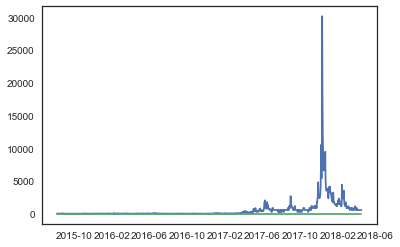

In [15]:
plt.plot(keyword_df['litecoin'])

In [16]:
keyword_df['litecoin'].index[-1] < end_date_format

False

In [17]:
keyword_df['litecoin'].iloc[-12:]

,litecoin,isPartial
2018-04-07,593.07,False
2018-04-08,593.07,False
2018-04-09,593.07,False
2018-04-10,593.07,False
2018-04-11,593.07,False
2018-04-12,593.07,False
2018-04-13,593.07,False
2018-04-14,593.07,False
2018-04-15,593.07,False
2018-04-16,593.07,False


In [18]:
keyword_df['litecoin'].describe()

,litecoin,isPartial
count,986.000000,986
unique,239.000000,1
top,603.273614,False
freq,78.000000,986


In [19]:
for search_term in keywords:
    keyword_df[search_term].drop(['isPartial'], axis=1, inplace=True)
    
    keyword_df[search_term].reset_index(level=0, inplace=True)
    keyword_df[search_term].rename(index=str, columns={"index": "Date"}, inplace=True)
    
    keyword_df[search_term].columns =[keyword_df[search_term].columns[0]]+[i+"_trends" for i in keyword_df[search_term].columns[1:]]
    
    keyword_df[search_term].to_pickle("data/"+search_term+"_trends.pkl")

## Combine all the data sources to create the full dataset

In [20]:
coin_symbol = {'bitcoin': 'btc', 'ethereum': 'eth', 'litecoin': 'ltc', 'ripple': 'xrp'}

for coin in coins:
    coin_df[coin].columns =[coin_df[coin].columns[0]]+[coin_symbol[coin]+"_"+i for i in coin_df[coin].columns[1:]]

In [21]:
market_df = pd.DataFrame()
# for coin in coins:
#     market_df = pd.merge(market_df, coin_df[coin], on=['Date'])

market_df1 = pd.merge(coin_df['bitcoin'], coin_df['ethereum'], on=['Date'])
market_df2 = pd.merge(coin_df['litecoin'], coin_df['ripple'], on=['Date'])
market_df = pd.merge(market_df1, market_df2, on=['Date'])

market_df = market_df[market_df['Date']>=start_date_]

In [22]:
# New features
# Target variable: Daily percentage returns
for coin, symbol in coin_symbol.items():
    kwargs = {symbol+'_close_off_high': lambda x: 1-2*(x[symbol+'_High']-x[symbol+'_Close'])/(x[symbol+'_High']-x[symbol+'_Low']),
              symbol+'_volatility': lambda x: (x[symbol+'_High']- x[symbol+'_Low'])/x[symbol+'_Open'],
              symbol+'_daily_ret': lambda x: (x[symbol+'_Close']-x[symbol+'_Open'])/x[symbol+'_Open']
             }
    market_df = market_df.assign(**kwargs)

market_df.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap,eth_Open,eth_High,eth_Low,...,btc_daily_ret,eth_close_off_high,eth_volatility,eth_daily_ret,ltc_close_off_high,ltc_volatility,ltc_daily_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret
0,2015-08-07,278.74,280.39,276.37,279.58,42484800,4032820000,2.830000,3.540000,2.520000,...,0.003014,-0.509804,0.360424,-0.021201,0.920000,0.061576,0.036946,0.987805,0.020449,0.016459
1,2015-08-08,279.74,279.93,260.71,261.00,58533000,4048270000,2.790000,2.800000,0.714725,...,-0.066991,-0.962979,0.747410,-0.729991,-0.947368,0.090047,-0.087678,0.147059,0.066634,0.038217
2,2015-08-09,261.12,267.00,260.47,265.08,23789600,3779770000,0.706136,0.879810,0.629191,...,0.015165,-0.419789,0.354916,-0.006003,0.058824,0.044271,0.015625,0.914530,0.041372,0.038190
3,2015-08-10,265.48,267.03,262.60,264.47,20979400,3843850000,0.713989,0.729854,0.636546,...,-0.003804,0.541175,0.130685,-0.007761,0.250000,0.020513,0.012821,-0.949686,0.018044,-0.007036
4,2015-08-11,264.34,270.39,264.09,270.39,25433900,3828500000,0.708087,1.130000,0.663235,...,0.022887,0.742911,0.659192,0.511114,1.000000,0.055696,0.053165,-1.000000,0.019998,-0.018284


In [23]:
for search_term in keywords:
    market_df = market_df.merge(keyword_df[search_term], on=['Date'])

In [24]:
keyword_df['litecoin'].head()

,Date,litecoin_trends
0,2015-08-07,35
1,2015-08-08,57
2,2015-08-09,30
3,2015-08-10,55
4,2015-08-11,36


In [25]:
market_df.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap,eth_Open,eth_High,eth_Low,...,ltc_close_off_high,ltc_volatility,ltc_daily_ret,xrp_close_off_high,xrp_volatility,xrp_daily_ret,bitcoin_trends,ethereum_trends,litecoin_trends,ripple_trends
0,2015-08-07,278.74,280.39,276.37,279.58,42484800,4032820000,2.830000,3.540000,2.520000,...,0.920000,0.061576,0.036946,0.987805,0.020449,0.016459,33,47,35,69
1,2015-08-08,279.74,279.93,260.71,261.00,58533000,4048270000,2.790000,2.800000,0.714725,...,-0.947368,0.090047,-0.087678,0.147059,0.066634,0.038217,29,43,57,72
2,2015-08-09,261.12,267.00,260.47,265.08,23789600,3779770000,0.706136,0.879810,0.629191,...,0.058824,0.044271,0.015625,0.914530,0.041372,0.038190,30,45,30,71
3,2015-08-10,265.48,267.03,262.60,264.47,20979400,3843850000,0.713989,0.729854,0.636546,...,0.250000,0.020513,0.012821,-0.949686,0.018044,-0.007036,31,35,55,73
4,2015-08-11,264.34,270.39,264.09,270.39,25433900,3828500000,0.708087,1.130000,0.663235,...,1.000000,0.055696,0.053165,-1.000000,0.019998,-0.018284,32,37,36,63


In [26]:
# SAVE THE DATAFRAME

market_df.to_pickle("data/full_dataset.pkl")

In [27]:
coin_df['litecoin'].head()

,Date,ltc_Open,ltc_High,ltc_Low,ltc_Close,ltc_Volume,ltc_Market Cap
0,2015-08-07,4.06,4.22,3.97,4.21,4192810,168474000
1,2015-08-08,4.22,4.22,3.84,3.85,4917730,175126000
2,2015-08-09,3.84,3.98,3.81,3.90,3064680,159570000
3,2015-08-10,3.90,3.98,3.90,3.95,2239890,162062000
4,2015-08-11,3.95,4.16,3.94,4.16,3426300,164164000


In [28]:
coin_df['ripple'].head()

,Date,xrp_Open,xrp_High,xrp_Low,xrp_Close,xrp_Volume,xrp_Market Cap
0,2015-08-07,0.008020,0.008153,0.007989,0.008152,363643,255895000
1,2015-08-08,0.008164,0.008708,0.008164,0.008476,678295,260486000
2,2015-08-09,0.008484,0.008823,0.008472,0.008808,531969,270702000
3,2015-08-10,0.008812,0.008905,0.008746,0.008750,472973,281170000
4,2015-08-11,0.008751,0.008766,0.008591,0.008591,282461,279220000
